In [8]:
%%capture
!pip install ultralytics torchviz sentence_transformers

In [61]:
from ultralytics import YOLO
from PIL import Image as PilImage
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sentence_transformers import SentenceTransformer, util
import string
import torch.nn.functional as F

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# paths
root_path = '/content/drive/My Drive/EE 5561 Course Project/'
blended_images_path = os.path.join(root_path, 'final_dataset')

# root_path = os.getcwd()
# blended_images_path = os.path.join(root_path, 'final_dataset')

In [17]:
len(os.listdir(os.path.join(root_path, 'new_noise_captcha_dataset')))

1000

In [18]:
blended_images = []
for filename in os.listdir(blended_images_path):
    captcha_text, object_name = filename[:-4].split('_')
    image_path = os.path.join(blended_images_path, filename)
    blended_image = PilImage.open(image_path)
    blended_images.append((captcha_text, object_name, blended_image))

In [19]:
## Function to denoise image using Non-Local Means
## to test the effect of possible denoising applied by future CAPTCHA solvers
def denoise_image(image):
    """Denoises an RGB image using OpenCV's non-local means denoising.

    Args:
      image_path: Path to the image file.

    Returns:
      Denoised image as a NumPy array.
    """

    # Read the image
    img = np.array(image)

    # Apply non-local means denoising
    denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    return PilImage.fromarray(denoised_img)

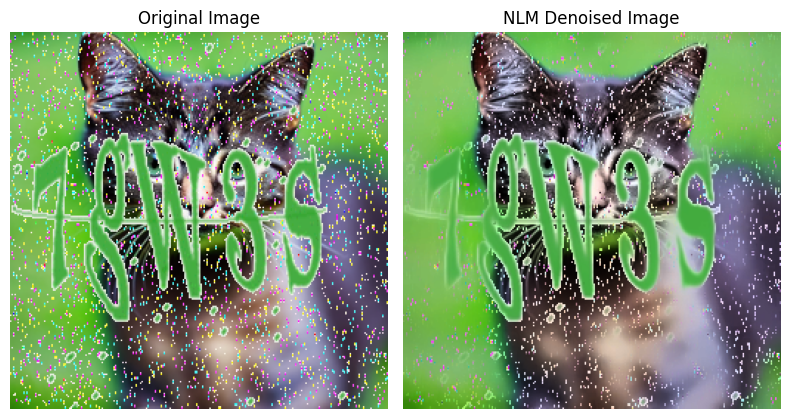

In [34]:
## USE FOR REPORT

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].imshow(blended_images[0][2])
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(denoise_image(blended_images[0][2]))
ax[1].set_title('NLM Denoised Image')
ax[1].axis('off')

plt.tight_layout()

## YOLO v8 model with Semantic Similarity check

In [32]:
%%capture
# YOLOv8 model and SentenceTransformer model
yolo_model = YOLO("yolov8m.pt").to(device) # object detection model
semantic_model = SentenceTransformer('all-MiniLM-L6-v2') # Semantic Similarity model

In [33]:
# Function to calculate semantic similarity
def calculate_similarity(true_label, predicted_label):
    embeddings = semantic_model.encode([true_label, predicted_label], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return similarity

In [57]:
%%capture
## YOLO model top prediction
## and Semantic Similarity calculation

# Initializing counters for correct matches
exact_match_correct = 0
semantic_match_correct = 0
total_correct = 0
total_wrong = 0
total_images = len(blended_images)  # total number of images

# List to store results
detailed_results = []  # each entry: (captcha_text, object_name, blended_image, top_prediction, semantic_score)

for idx, (captcha_text, object_name, blended_image) in enumerate(blended_images[:10]):
    # YOLO model predictions
    results = yolo_model(blended_image)

    # Get the top prediction from YOLO
    detected_classes = [
        (yolo_model.names[int(box.cls)], box.conf.item())  # (class_name, confidence_score)
        for box in results[0].boxes
    ]
    sorted_predictions = sorted(detected_classes, key=lambda x: x[1], reverse=True)
    top_prediction = sorted_predictions[0][0] if sorted_predictions else None

    # Check for an exact match
    if top_prediction == object_name:
        exact_match_correct += 1
        total_correct += 1
        match_type = "Exact Match"
        semantic_score = 1.0  # Perfect match
    else:
        # Semantic similarity score
        semantic_score = calculate_similarity(object_name, top_prediction)
        if semantic_score > 0.7:  # Semantic match threshold
            semantic_match_correct += 1
            total_correct += 1
            match_type = "Semantic Match"
        else:
            total_wrong += 1
            match_type = "Mismatch"

    # Store detailed results
    detailed_results.append((captcha_text, object_name, blended_image, top_prediction, semantic_score, match_type))


0: 640x640 1 bench, 1480.5ms
Speed: 3.9ms preprocess, 1480.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 scissors, 1401.1ms
Speed: 3.0ms preprocess, 1401.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 handbag, 1121.2ms
Speed: 2.6ms preprocess, 1121.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 umbrella, 1 surfboard, 2 scissorss, 1126.0ms
Speed: 2.5ms preprocess, 1126.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bus, 1 bench, 1119.9ms
Speed: 2.5ms preprocess, 1119.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1091.1ms
Speed: 1.9ms preprocess, 1091.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1076.1ms
Speed: 2.2ms preprocess, 1076.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 1087.1ms
Sp

In [58]:
exact_match_accuracy = exact_match_correct / len(blended_images[:50]) * 100
semantic_match_accuracy = (exact_match_correct + semantic_match_correct) / len(blended_images[:50]) * 100

print(f"Exact Match Accuracy: {exact_match_accuracy:.2f}%")
print(f"Semantic Match Accuracy: {semantic_match_accuracy:.2f}%")
print(f"Total Correct Predictions: {total_correct}")
print(f"Total Wrong Predictions: {total_wrong}")

Exact Match Accuracy: 0.00%
Semantic Match Accuracy: 0.00%
Total Correct Predictions: 0
Total Wrong Predictions: 10


In [101]:
detailed_results[0]

('7gW3s',
 'cat',
 <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=256x256>,
 'bench',
 0.22832952439785004,
 'Mismatch')

In [106]:
calculate_similarity('airplane', 'plane') # (object_name, top_prediction)

0.8522153496742249

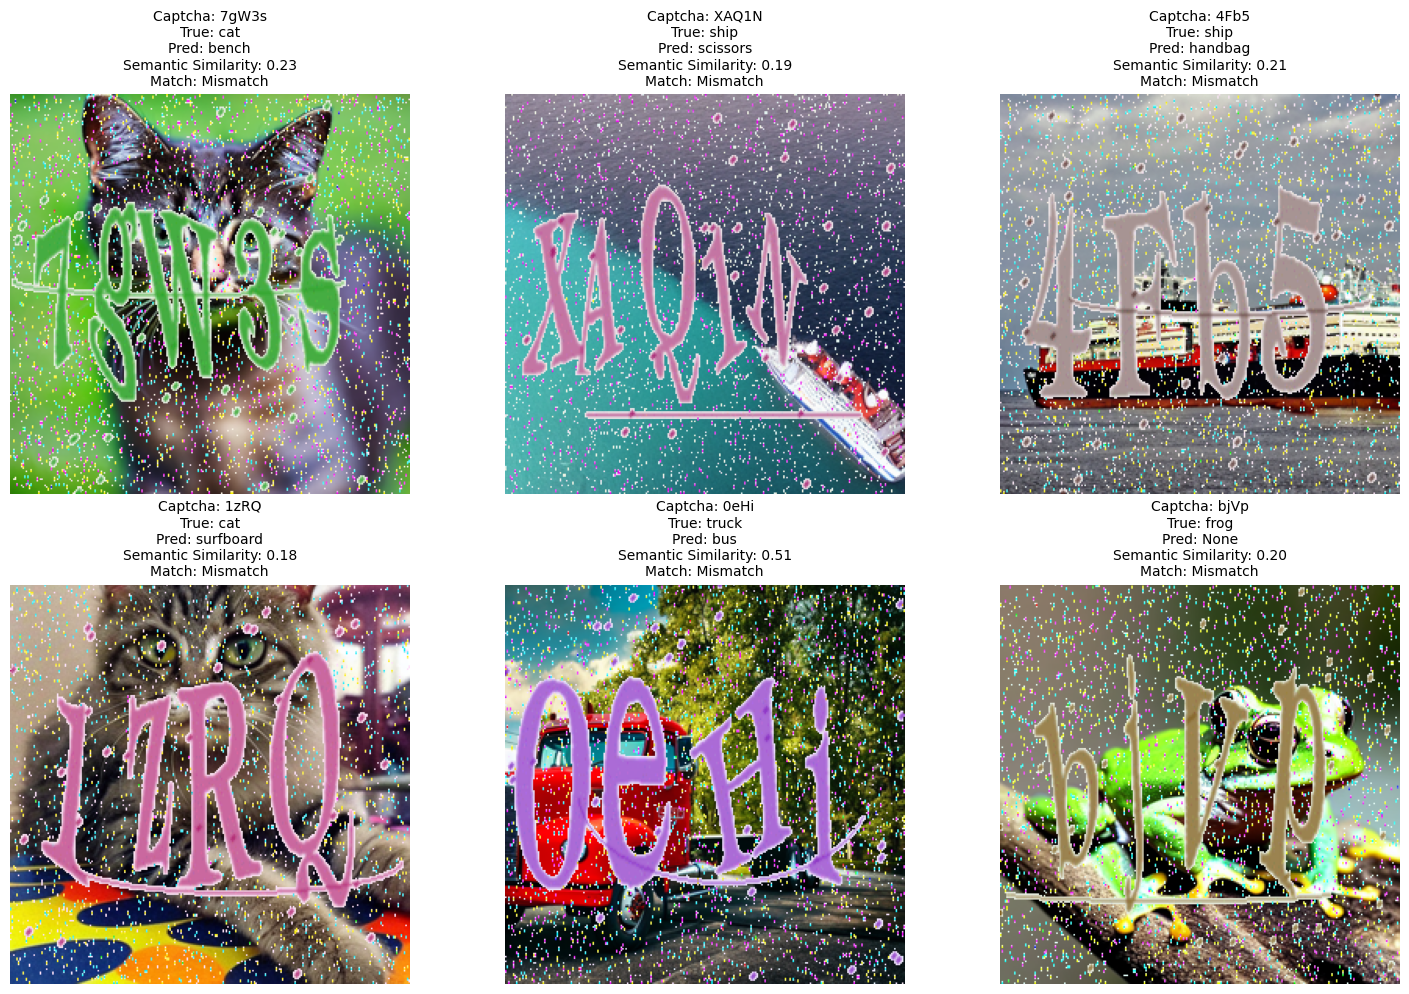

In [60]:
## USE FOR REPORT
## Few examples of results with the image and details
num_examples = 6
num_cols = 3
num_rows = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for idx, result in enumerate(detailed_results[:num_examples]):
    row, col = divmod(idx, num_cols)
    ax = axes[row, col]

    # unpacking the result
    captcha_text, true_label, blended_image, top_prediction, semantic_score, match_type = result

    # blended image
    ax.imshow(blended_image)
    ax.axis("off")

    semantic_score_text = f"{semantic_score:.2f}" if semantic_score is not None else "N/A"

    # Set title with details
    ax.set_title(
        f"Captcha: {captcha_text}\n"
        f"True: {true_label}\n"
        f"Pred: {top_prediction}\n"
        f"Semantic Similarity: {semantic_score_text}\n"
        f"Match: {match_type}",
        fontsize=10
    )

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## CRNN Model for CAPTCHA charcater recognition

In [20]:
## CRNN model
class CRNN(nn.Module):
    def __init__(self, num_symbols):
        super(CRNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Conv1: Input channels = 1 (grayscale), Output channels = 64
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Height: 128 -> 64, Width: 180 -> 90

            # Conv2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Height: 64 -> 32, Width: 90 -> 45

            # Conv3
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # Height: 32 -> 16, Width: 45 -> 22

            # Conv4
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((2, 1)),  # Height: 16 -> 8, Width: 22 -> 22 (no change in width)

            # Conv5
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d((2, 1)),  # Height: 8 -> 4, Width: 22 -> 22 (no change in width)

            # Conv6: Final layer to ensure height = 1
            nn.Conv2d(512, 512, kernel_size=(4, 1)),  # Kernel matches height to reduce it to 1
            nn.ReLU(),
        )

        # RNN (Bidirectional LSTM)
        self.rnn = nn.LSTM(512, 256, bidirectional=True, num_layers=2, batch_first=True)

        # fully connected layer to predict characters
        self.fc = nn.Linear(512, num_symbols+1)

    def forward(self, x):
        features = self.conv_layers(x)  # format of x is (batch, channels, height, width)
        b, c, h, w = features.size()
        assert h == 1, "height after convolution should be 1"
        features = features.squeeze(2)  # (batch, channels, width)
        features = features.permute(0, 2, 1)  # (batch, width, channels)
        features, _ = self.rnn(features)  # RNN output (batch, width, 2*hidden_size)
        outputs = self.fc(features)  # final prediction (batch, width, num_symbols + 1)
        return outputs

In [34]:
# Symbols (52 letters + 10 digits)
symbols = string.ascii_letters + string.digits
NUM_SYMBOLS = len(symbols)  # 62 symbols (a-z, A-Z, 0-9)

# Constants
IMG_HEIGHT = 128
IMG_WIDTH = 180
BATCH_SIZE = 32

In [35]:
symbols = string.ascii_letters + string.digits # total number of possible symbols or characters in CAPTCHA

In [36]:
crnn_model = CRNN(num_symbols=len(symbols)).to(device)

crnn_model.load_state_dict(torch.load('/content/crnn_epoch_40.pth',  map_location=device)) # loading the model weights for the 40th epoch checkpoint

<All keys matched successfully>

CRNN Predicted Label:  7ThB


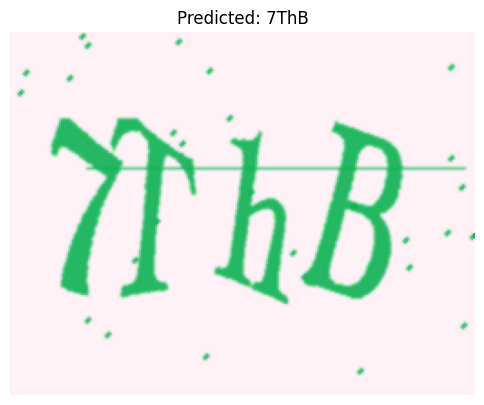

In [54]:
## Testing the model on a singular image

test_img_path = '/content/7ThB.png'
test_img = PilImage.open(test_img_path).convert('L')  # Convert to grayscale if required

# applying the same transformations as during training
transform = transforms.Compose([
    transforms.Resize((128, 180)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalization
])
single_image = transform(test_img).unsqueeze(0).to(device)  # Add batch dimension and move to GPU

# model to eval mode
crnn_model.eval()
with torch.no_grad():
    output = crnn_model(single_image)  # Get the model's predictions

# reshaping and process the output
output = output.permute(1, 0, 2)  # Reshape to (sequence_length, batch_size, num_classes)
predictions = torch.argmax(torch.softmax(output, dim=2), dim=2).squeeze(1).cpu().numpy()

# decoding the predictions, filtering out invalid indices
predicted_label = [symbols[idx] for idx in predictions if idx < NUM_SYMBOLS]

# results
print("CRNN Predicted Label: ", "".join(predicted_label))


plt.figure(figsize=(6, 6))
plt.imshow(np.array(PilImage.open(test_img_path)))  # Grayscale image
plt.title(f"Predicted: {''.join(predicted_label)}")
plt.axis("off")
plt.show()

In [46]:
# Model evaluations
def evaluate_models(image_path, yolo_model, crnn_model, symbols, device):
    """
    Evaluates the given image using YOLO and CRNN models.

    Args:
        image_path (str): Path to the input CAPTCHA image.
        yolo_model (YOLO): Pretrained YOLOv8 model.
        crnn_model (nn.Module): Trained CRNN model.
        symbols (list): List of valid characters for CRNN decoding.
        device (str): Device to run the models on ("cuda" or "cpu").

    Returns:
        None: Prints the predictions and outcomes of both models.
    """
    # Extract CAPTCHA text and object name from the filename
    filename = image_path.split("/")[-1]
    captcha_text, object_name = filename.split("_")[0], filename.split("_")[1].split(".")[0]

    print(f"\nProcessing Image: {filename}")
    print(f"Ground Truth - CAPTCHA Text: {captcha_text}, Object Label: {object_name}")

    # --- YOLO Model Prediction ---
    test_img = PilImage.open(image_path).convert("RGB")  # Keep it RGB for YOLO
    results = yolo_model(test_img)

    # Get the top prediction
    detected_classes = [
        (yolo_model.names[int(box.cls)], box.conf.item())  # (class_name, confidence_score)
        for box in results[0].boxes
    ]
    sorted_predictions = sorted(detected_classes, key=lambda x: x[1], reverse=True)
    top_prediction = sorted_predictions[0][0] if sorted_predictions else None

    # Check for exact match or semantic similarity
    if top_prediction == object_name:
        yolo_match_type = "Exact Match"
        yolo_result = "YOLO model passed the CAPTCHA"
    else:
        semantic_score = calculate_similarity(object_name, top_prediction)
        if semantic_score > 0.7:
            yolo_match_type = "Semantic Match"
            yolo_result = "YOLO model passed the CAPTCHA"
        else:
            yolo_match_type = "No Match"
            yolo_result = "YOLO model failed the CAPTCHA"

    print(f"YOLO Model Prediction: {top_prediction}")
    print(f"Match Type: {yolo_match_type}")
    print(yolo_result)

    # --- CRNN Model Prediction ---
    # Apply the same transformations as during CRNN training
    transform = transforms.Compose([
        transforms.Resize((128, 180)),  # Resize to match CRNN input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])  # Grayscale normalization
    ])

    crnn_input = transform(PilImage.open(image_path).convert("L")).unsqueeze(0).to(device)

    crnn_model.eval()
    with torch.no_grad():
        output = crnn_model(crnn_input)  # Get CRNN model predictions

    # Reshape and decode predictions
    output = output.permute(1, 0, 2)  # Shape: (sequence_length, batch_size, num_classes)
    probs = F.softmax(output, dim=2)
    predictions = torch.argmax(probs, dim=2).squeeze(1).cpu().numpy()
    predicted_label = ''.join([symbols[idx] for idx in predictions if idx < len(symbols)])

    # CRNN Evaluation
    if predicted_label == captcha_text:
        crnn_result = "CRNN model passed the CAPTCHA"
    else:
        crnn_result = "CRNN model failed the CAPTCHA"

    print(f"CRNN Model Prediction: {predicted_label}" if predicted_label is None else "CRNN Model Prediction: No Prediction")
    print(crnn_result)

    # --- Combined Result ---
    if yolo_result == "YOLO model passed the CAPTCHA" and crnn_result == "CRNN model passed the CAPTCHA":
        print("CAPTCHA prediction successful by ML models")
    else:
        print("CAPTCHA prediction failed by ML models")

    plt.imshow(test_img)
    plt.title(f"YOLO Prediction: {top_prediction}\nCRNN Prediction: {predicted_label}\nGround Truth: {filename[:-4]}")
    plt.axis("off")
    plt.show()

In [52]:
# Example Usage
image_path = '/content/7A2F_deer.png'  # Replace with your image path
device = 'cuda' if torch.cuda.is_available() else 'cpu'


Processing Image: 7A2F_deer.png
Ground Truth - CAPTCHA Text: 7A2F, Object Label: deer

0: 640x640 1 chair, 1175.5ms
Speed: 3.1ms preprocess, 1175.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
YOLO Model Prediction: chair
Match Type: No Match
YOLO model failed the CAPTCHA
CRNN Model Prediction: No Prediction
CRNN model failed the CAPTCHA
CAPTCHA prediction failed by ML models


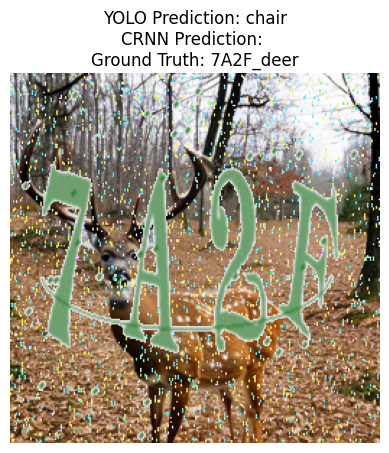

In [53]:
# Call the function
evaluate_models(image_path, yolo_model, crnn_model, symbols, device)